### Load Packages

In [5]:
import pathlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tqdm
%matplotlib notebook
from IPython import display
import pandas as pd
import sys, subprocess
from PIL import Image
import pickle
from armcodlib import *
import keras.backend as K
import os
import cv2
from glob import glob

Using TensorFlow backend.


In [6]:
print(tf.__version__)

2.0.0-alpha0


### Create arm positions dataset

Fixing parameters 

Creation of the training data: 
- train_posture_before : joint angles before command
- train_posture_after  : joint angles after command is applied
- command : command applied
- train_position_before : end effector position before command
- train_position_after : end effector position after command is applied.

In [3]:
NB_POSTURE = 50
NB_COMMAND = 100
NB_DATA = NB_POSTURE*NB_COMMAND
BATCH_SIZE = 100
TEST_BUF = 1000
IMG_SIZE = 64
DIMS = (IMG_SIZE, IMG_SIZE,2)
N_TRAIN_BATCHES =int(NB_DATA/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

train_posture_before, train_posture_after, train_command, train_position_before, train_position_after  = create_random_data(NB_POSTURE, NB_COMMAND, "train")
train_images = load_and_process_images(NB_DATA, "train")
#test_posture_before, test_posture_after, test_command, test_position_before, test_position_after = create_random_data(10,10, "test")
#test_images = load_and_process_images(100, "test")

100%|██████████| 5000/5000 [00:17<00:00, 278.06it/s]


Saving the training data

In [4]:
train_images_pickle = open("pickles/train_images.pickle", "wb")
#test_images_pickle = open("pickles/test_images.pickle", "wb")
train_command_pickle = open("pickles/train_command.pickle", "wb")
#test_command_pickle = open("pickles/test_command.pickle", "wb")

pickle.dump(train_images, train_images_pickle)
#pickle.dump(test_images, test_images_pickle)
pickle.dump(train_command, train_command_pickle)
#pickle.dump(test_command, test_command_pickle)

train_images_pickle.close()
#test_images_pickle.close()
#test_command_pickle.close()
train_command_pickle.close()

Creation of the tf.dataset

In [4]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_images[:,:,:,],train_images[:,:,:,1:]))
    .repeat(10)
    .shuffle(NB_DATA)
    .batch(BATCH_SIZE)
)

train_dataset_x = (
    tf.data.Dataset.from_tensor_slices((train_images[:,:,:,],train_images[:,:,:,:0]))
    .repeat(10)
    .shuffle(NB_DATA)
    .batch(BATCH_SIZE)
)

#test_dataset = (
#    tf.data.Dataset.from_tensor_slices((test_images, test_images[:,:,:,1:]))
#    .shuffle(TEST_BUF)
#    .batch(BATCH_SIZE)
#)

visu_dataset = (
    tf.data.Dataset.from_tensor_slices((train_images[:,:,:,]))
    .repeat(10)
    .shuffle(NB_DATA)
)

In [15]:
train_dataset

<BatchDataset shapes: ((None, 64, 64, 2), (None, 64, 64, 1)), types: (tf.float32, tf.float32)>

### Define the network architecture

In [6]:
encoder = build_dense_encoder()
decoder = build_dense_decoder()

### Create Model

In [7]:
optimizer = tf.keras.optimizers.Adam(1e-3)

autoencoder = tf.keras.Model(encoder.input, decoder(encoder(encoder.input)), name = "autoencoder")

autoencoder.compile(optimizer = optimizer, 
             loss='mse',
             metrics=['accuracy','kullback_leibler_divergence'])

In [8]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 64, 64, 2)]       0         
_________________________________________________________________
encoder_model (Model)        (None, 1, 64)             295008    
_________________________________________________________________
decoder_model (Model)        (None, 64, 64, 1)         171136    
Total params: 466,144
Trainable params: 466,144
Non-trainable params: 0
_________________________________________________________________


### Train model

In [20]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = autoencoder.fit(train_dataset, 
                    epochs = 50,
                    steps_per_epoch = 10,
                    callbacks=[tensorboard_callback])

Epoch 1/50
10/10 [==============================] - 0s 42ms/step - loss: 0.0058 - accuracy: 0.0000e+00 - kullback_leibler_divergence: 0.0560
Epoch 2/50
10/10 [==============================] - 0s 28ms/step - loss: 0.0056 - accuracy: 0.0000e+00 - kullback_leibler_divergence: 0.0569
Epoch 3/50
10/10 [==============================] - 0s 30ms/step - loss: 0.0057 - accuracy: 0.0000e+00 - kullback_leibler_divergence: 0.0578
Epoch 4/50
10/10 [==============================] - 0s 29ms/step - loss: 0.0057 - accuracy: 0.0000e+00 - kullback_leibler_divergence: 0.0586
Epoch 5/50
10/10 [==============================] - 0s 29ms/step - loss: 0.0058 - accuracy: 0.0000e+00 - kullback_leibler_divergence: 0.0603
Epoch 6/50
10/10 [==============================] - 0s 26ms/step - loss: 0.0056 - accuracy: 0.0000e+00 - kullback_leibler_divergence: 0.0607
Epoch 7/50
10/10 [==============================] - 0s 26ms/step - loss: 0.0056 - accuracy: 0.0000e+00 - kullback_leibler_divergence: 0.0624
Epoch 8/50
10

In [10]:
example_data = next(iter(train_dataset))

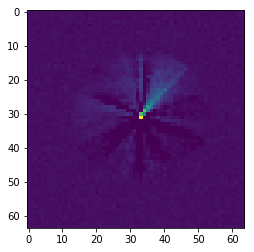

In [11]:
imshow(autoencoder.predict(example_data)[0,:,:,0])

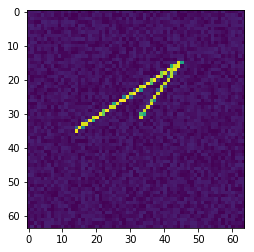

In [12]:
imshow(example_data[0][0,:,:,1])

### Alternative convolutional model

In [5]:
encoder_conv = build_conv2D_encoder()
decoder_dense = build_dense_decoder()

In [6]:
optimizer = tf.keras.optimizers.Adam(1e-3)

autoencoder_conv = tf.keras.Model(encoder_conv.input, decoder_dense(encoder_conv(encoder_conv.input)), name = "autoencoder")

autoencoder_conv.compile(optimizer = 'adam', 
             loss='mse',
             metrics=['accuracy','kullback_leibler_divergence'])

In [7]:
autoencoder_conv.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 64, 64, 2)]       0         
_________________________________________________________________
encoder_model (Model)        (None, 1, 64)             992096    
_________________________________________________________________
decoder_model (Model)        (None, 64, 64, 1)         171136    
Total params: 1,163,232
Trainable params: 1,163,232
Non-trainable params: 0
_________________________________________________________________


In [17]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = autoencoder_conv.fit(train_dataset, 
                    epochs = 10)#, 
                    #steps_per_epoch = 50)
                    #callbacks=[tensorboard_callback])

Epoch 1/10
500/500 [==============================] - 27s 55ms/step - loss: 0.0032 - accuracy: 0.0000e+00 - kullback_leibler_divergence: 0.1833
Epoch 2/10
500/500 [==============================] - 27s 54ms/step - loss: 0.0032 - accuracy: 0.0000e+00 - kullback_leibler_divergence: 0.1833
Epoch 3/10
500/500 [==============================] - 27s 54ms/step - loss: 0.0032 - accuracy: 0.0000e+00 - kullback_leibler_divergence: 0.1835
Epoch 4/10
500/500 [==============================] - 27s 54ms/step - loss: 0.0032 - accuracy: 0.0000e+00 - kullback_leibler_divergence: 0.1835
Epoch 5/10
500/500 [==============================] - 27s 54ms/step - loss: 0.0032 - accuracy: 0.0000e+00 - kullback_leibler_divergence: 0.1835
Epoch 6/10
500/500 [==============================] - 27s 55ms/step - loss: 0.0031 - accuracy: 0.0000e+00 - kullback_leibler_divergence: 0.1835
Epoch 7/10
500/500 [==============================] - 27s 54ms/step - loss: 0.0031 - accuracy: 0.0000e+00 - kullback_leibler_divergence:

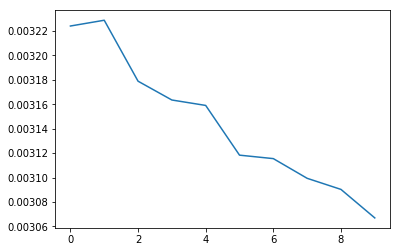

In [18]:
plt.plot(history.history['loss'])

In [14]:
example_data = next(iter(train_dataset))

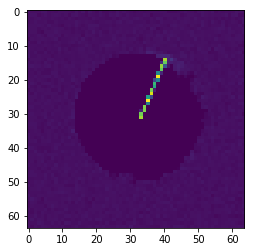

In [15]:
imshow(autoencoder_conv.predict(example_data)[0,:,:,0])

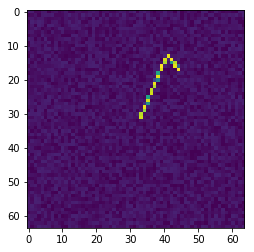

In [16]:
imshow(example_data[0][0,:,:,1])

### Visualization of ConvNet Filters

In [24]:
model = encoder_conv  
layer_name = 'conv_y_2'
input_layer = 'encoder_input'
intermediate_layer_model = tf.keras.Model(inputs=model.get_layer(input_layer).input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(example_data)


model = tf.keras.Sequential()
model.add(tf.keras.Input(shape = (64,64,1)))
model.add(intermediate_layer_model.layers[3])
model.add(intermediate_layer_model.layers[4])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_y_1 (Conv2D)            (None, 31, 31, 32)        320       
_________________________________________________________________
conv_y_2 (Conv2D)            (None, 15, 15, 64)        18496     
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_________________________________________________________________


/home/elias/.local/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


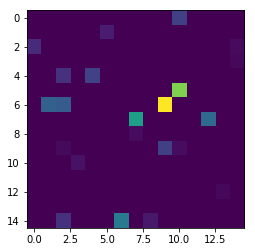

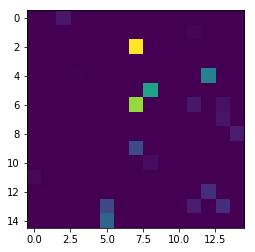

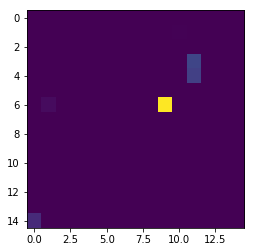

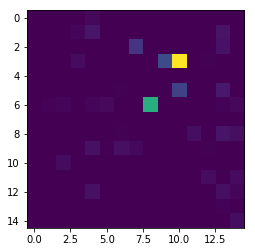

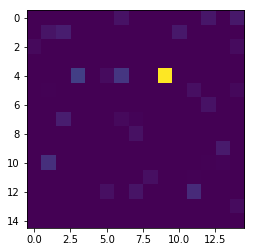

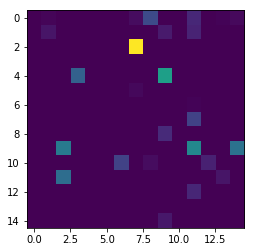

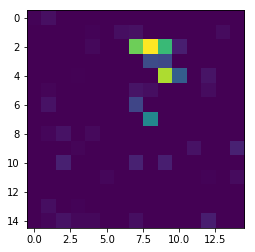

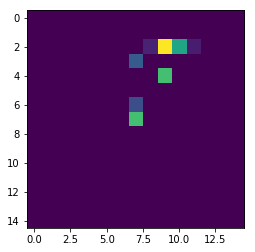

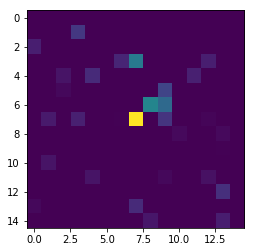

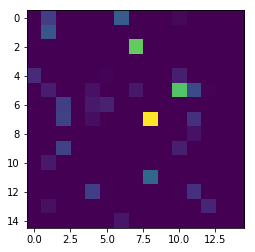

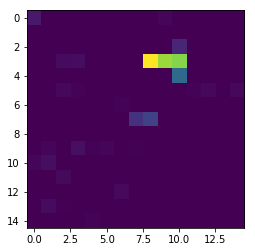

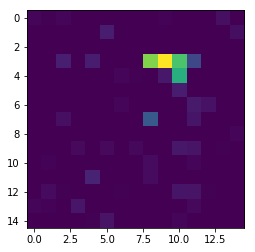

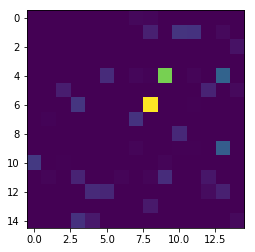

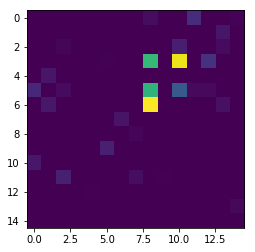

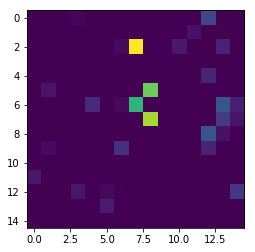

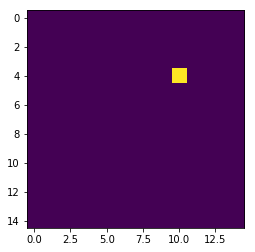

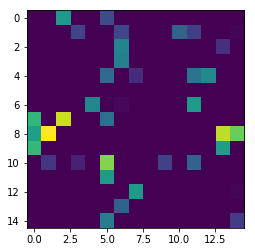

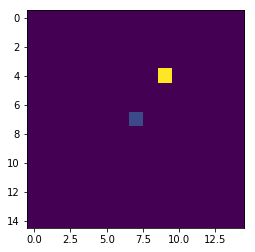

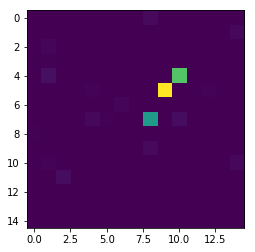

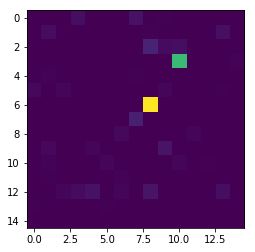

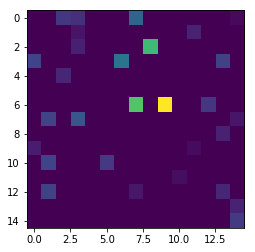

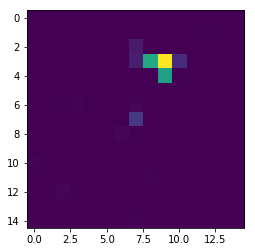

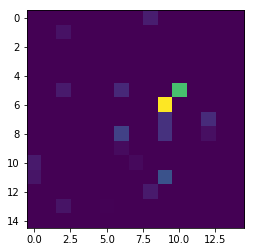

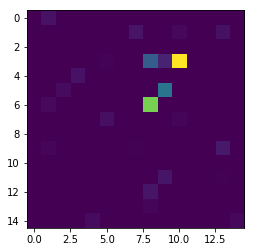

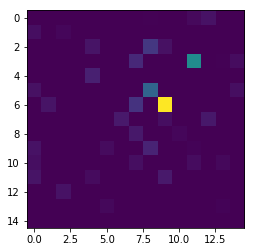

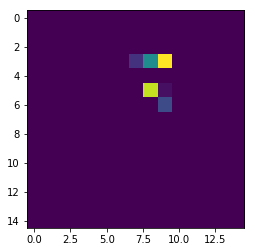

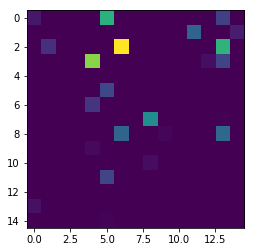

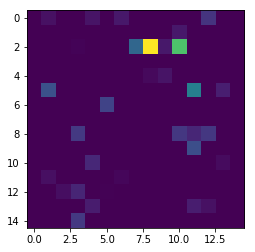

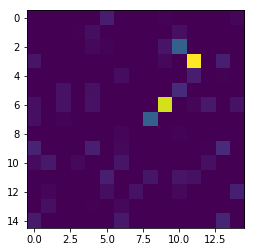

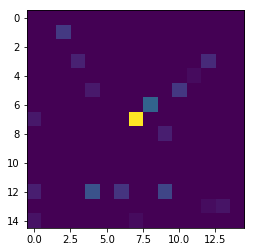

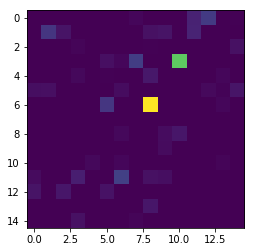

In [26]:
for i in range(31):
    plt.figure()
    plt.imshow(intermediate_output[0][:,:,i])

In [27]:
results = plot_and_compute_conv_filters(model)

  0%|          | 0/8 [00:00<?, ?it/s]


KeyboardInterrupt: 

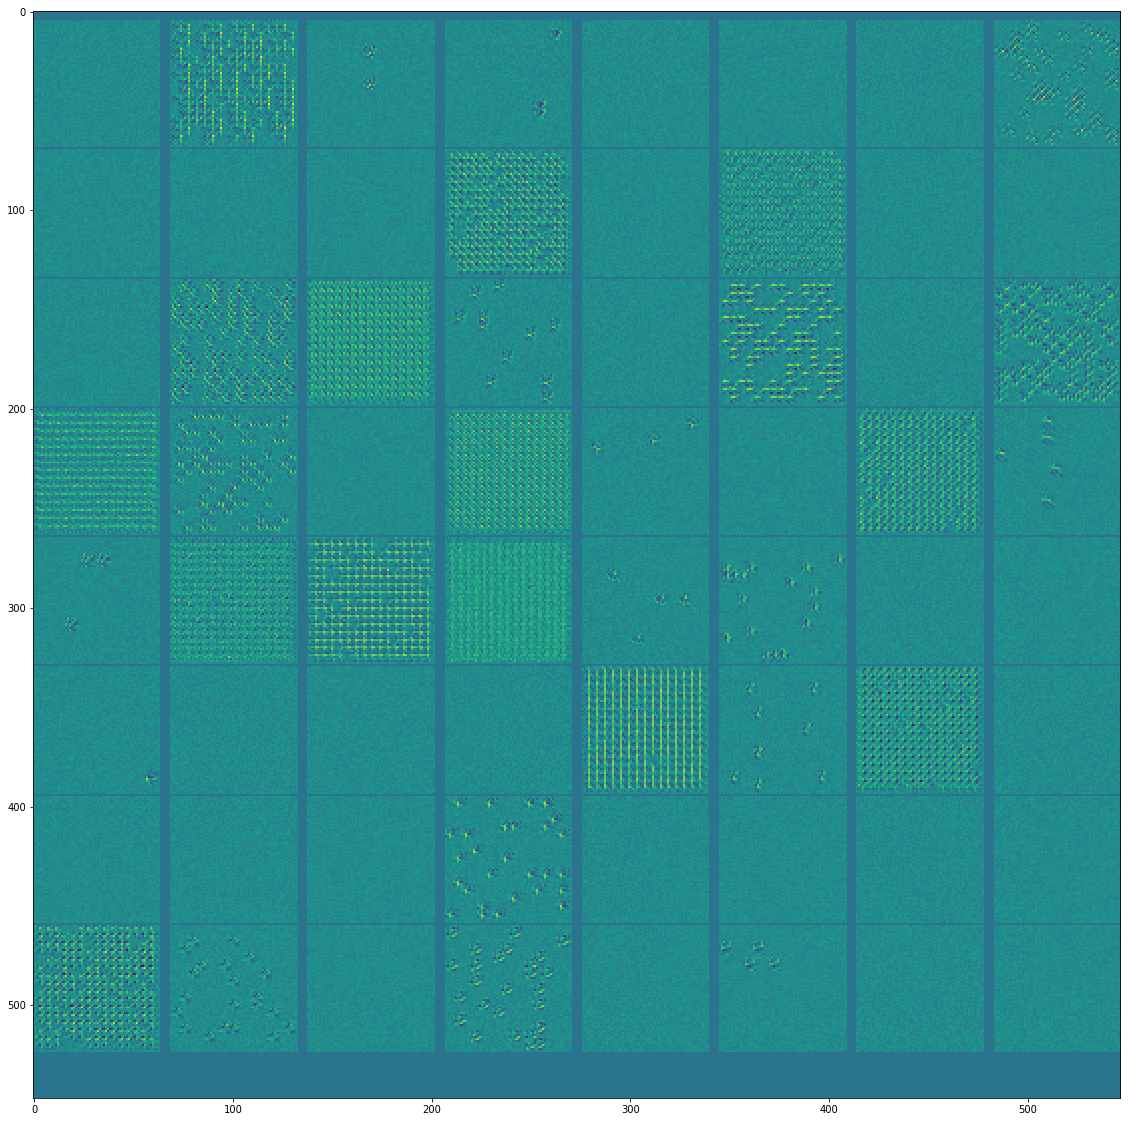

In [51]:
plt.figure(figsize=(20,20))
plt.imshow(results[:,:,0])
savefig('images/filter_conv_response.png')

### Visualization of dense layers

In [23]:
model = encoder_conv
model.output


<tf.Tensor 'concatenate/concat:0' shape=(None, 1, 64) dtype=float32>

In [38]:
size = 64
margin = 5
tt , results = plot_and_compute_last_filters(model, nb_pass=100000)

100%|██████████| 8/8 [1:24:18<00:00, 632.63s/it]A


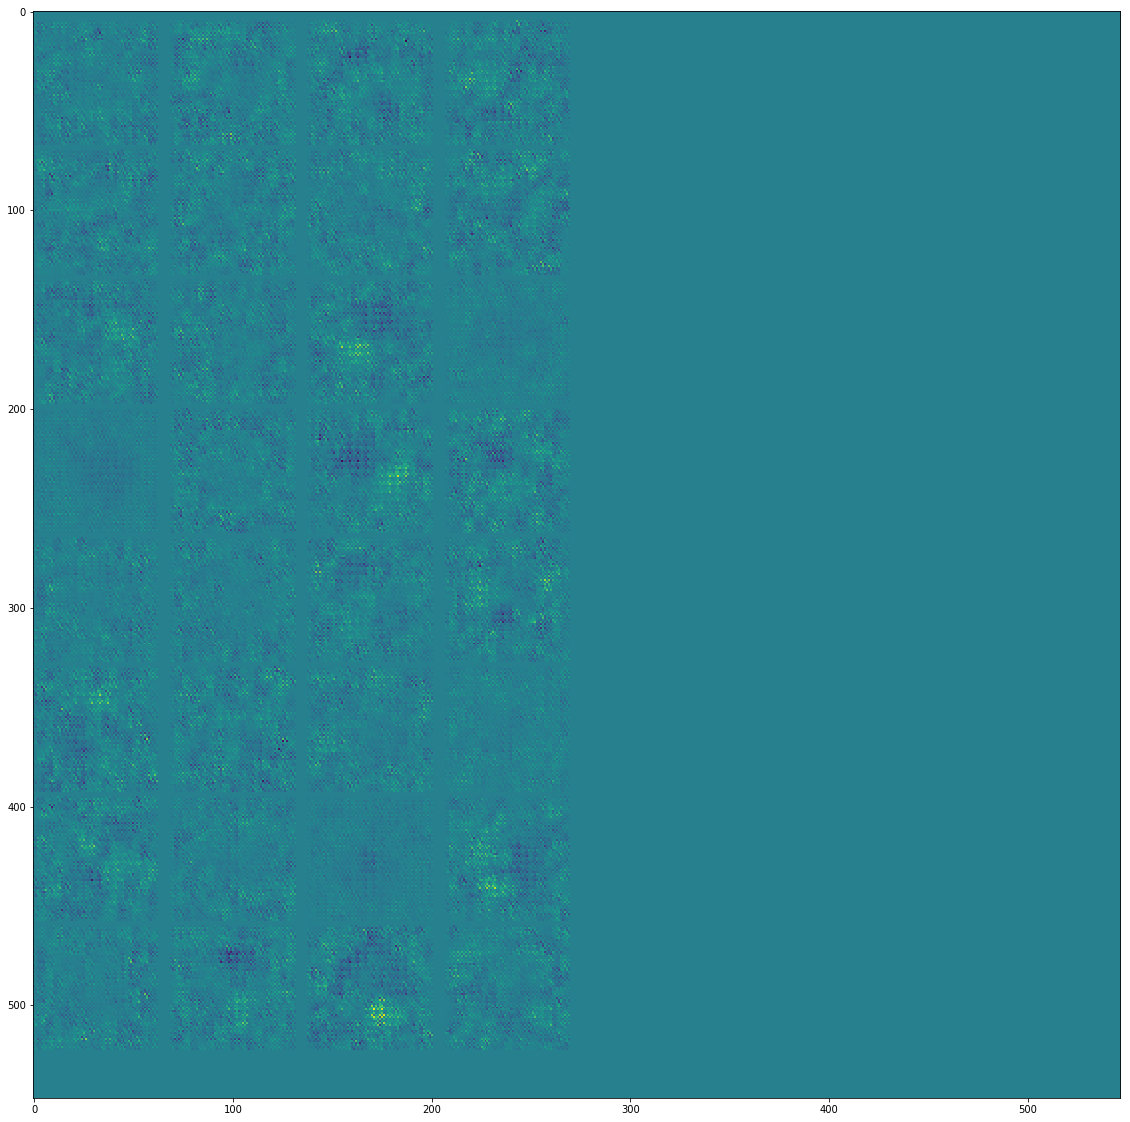

In [39]:
plt.figure(figsize=(20,20))
plt.imshow(results[:,:,0])
savefig('images/filter_response.png')

### t-SNE 

In [29]:
from sklearn.manifold import TSNE

In [30]:
def compute_latent_filters(model, iterator, nb_data):
    t = []
    color_position = []
    for i in tqdm.tqdm(range(nb_data)):
        tmp = iterator.get_next()
        
        tmp = tf.expand_dims(tmp, 0)
    
        j = check_color_position(i)
        
        t.append(model.predict(tmp))
        color_position.append(j)
    return t , color_position

def check_color_position(i):
    tmp = train_command[i]
    x, y, z = tmp[0][0], tmp[0][1], tmp[0][2]
    
    if (x > 0) and (y > 0) and (z > 0):
        j = 0
    elif (x > 0) and (y > 0) and (z < 0):
        j = 1
    elif (x > 0) and (y < 0) and (z > 0):
        j = 2
    elif (x > 0) and (y < 0) and (z < 0):
        j = 3
    elif (x < 0) and (y > 0) and (z > 0):
        j = 4
    elif (x < 0) and (y > 0) and (z < 0):
        j = 5
    elif (x < 0) and (y < 0) and (z > 0):
        j = 6
    elif (x < 0) and (y < 0) and (z < 0):
        j = 7
    else:
        j = 7

    return j

In [31]:
train_command

array([[[-0.15878108,  0.04611258,  0.12594576,  0.        ]],

       [[-0.37026639, -0.18505361, -0.37465003,  0.        ]],

       [[-0.33963404,  0.35526693,  0.26518168,  0.        ]],

       ...,

       [[-0.01482999,  0.29511188,  0.42023944,  0.        ]],

       [[ 0.24336465, -0.22726363, -0.3121104 ,  0.        ]],

       [[ 0.16602607, -0.27887428, -0.00519716,  0.        ]]])

In [32]:
t , color_position = compute_latent_filters(model, visu_dataset.__iter__(), 5000)

100%|██████████| 5000/5000 [00:09<00:00, 519.65it/s]


In [33]:
tsne = TSNE(n_components=2, random_state=0, perplexity=50, early_exaggeration=4)

In [45]:
t

[array([[[ 0.00580042, -0.04878208,  0.00271864, -0.64541066,
           0.0406537 ,  0.07282934, -0.20112619, -0.06245656,
          -0.0911344 , -0.0355597 , -0.06691495, -0.15870167,
           0.08889983,  0.05548472, -0.03159901, -0.04269343,
           0.01298864,  0.00821492, -0.09418634, -0.11218435,
          -0.06851586,  0.08656769, -0.6627197 , -0.00259142,
          -0.15912065, -0.09930249, -0.282153  ,  0.14747651,
          -0.12736037, -0.17145634,  0.00897403,  0.07268691,
          -0.20360442,  0.27616644,  0.8278138 ,  0.8976786 ,
          -0.55903345, -0.3265509 , -0.6157723 , -2.338638  ,
           0.20880915,  0.7327971 ,  0.3672776 ,  1.0684533 ,
          -0.17880659, -0.36282444, -0.834012  ,  1.5100696 ,
          -0.1802519 ,  2.4992452 ,  0.16738033,  0.0232222 ,
           0.30516407, -0.24239048,  0.45759422,  0.9504943 ,
           0.5719728 ,  1.2133143 , -0.5460665 ,  0.05839709,
          -0.60354537, -0.94923943, -0.94339013, -1.3123447 ]]],
     

In [35]:
g = []
for i in tqdm.tqdm(range(5000)):
    tmp = tf.keras.backend.flatten(t[i])
    g.append(tmp[32:])
    

100%|██████████| 5000/5000 [00:00<00:00, 10789.77it/s]


In [36]:
res = tsne.fit_transform(g)

100%|██████████| 5000/5000 [00:14<00:00, 337.93it/s]


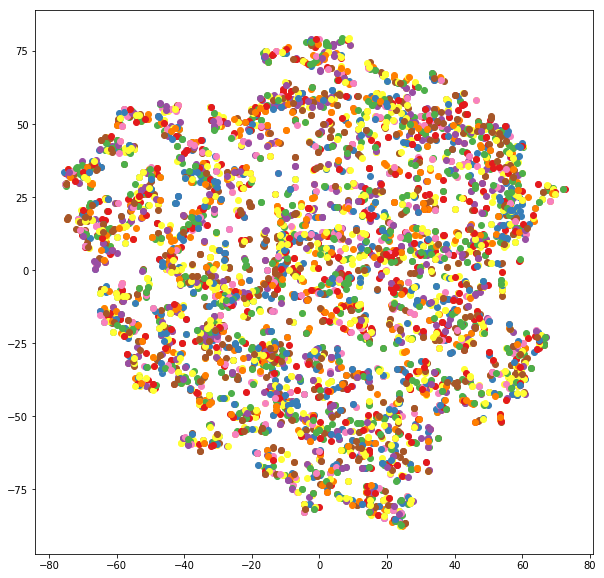

In [40]:
plt.figure(figsize=(10, 10))
nb_classes = 8
for i in tqdm.tqdm(range(5000)):
    label_id = color_position[i] 
    plt.scatter(res[i,0], 
               res[i,1], 
               color= plt.cm.Set1(label_id / float(nb_classes)))
plt.show()

100%|██████████| 5000/5000 [00:13<00:00, 204.43it/s]


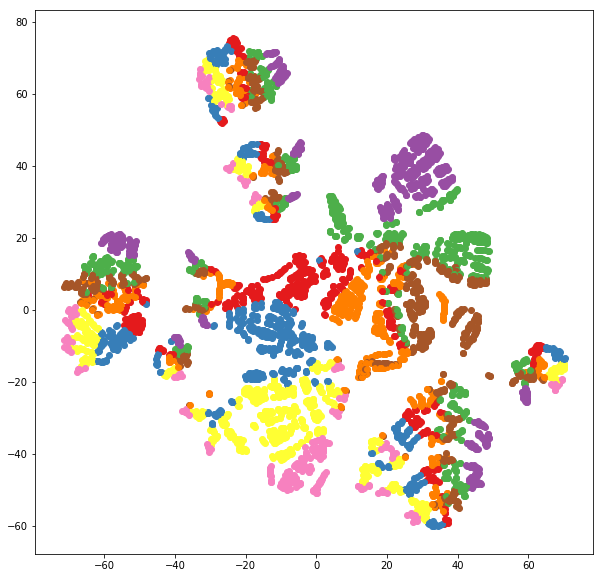

In [58]:
train_cmd = []
for i in tqdm.tqdm(range(5000)):
    tmp0 = tf.keras.backend.flatten(train_command[i])
    tmp1 = tf.keras.backend.flatten(train_position_before[i])
    tmp2 = tf.keras.backend.flatten(train_position_after[i])
    tmp3 = tf.keras.backend.concatenate([tmp0, tmp1, tmp2])
    train_cmd.append(tmp3)
tsnee = TSNE(n_components=2, random_state=0, perplexity=50, early_exaggeration=4)
tmp = tsnee.fit_transform(train_cmd)

plt.figure(figsize=(10, 10))
nb_classes = 8
for i in tqdm.tqdm(range(5000)):
    label_id = color_position[i] 
    plt.scatter(tmp[i,0], 
               tmp[i,1], 
               color= plt.cm.Set1(label_id / float(nb_classes)))
plt.show()


In [77]:
def plot_and_save_visual_direction(train_position_before, train_position_after):
    visual = visual_direction(train_position_before, train_position_after)
    for i in tqdm.tqdm(range(len(train_position_before))):
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.grid(False)
        #ax.set_autoscale_on(True)
        #ax.set_facecolor((0.0, 0.0, 0.0))
        #ax.set_xlim(-0., 0.5)
        #ax.set_ylim(-0., 0.5)
        #ax.set_zlim(-0., 0.5)
        ax.axis("off")
        q = ax.quiver(train_position_before[i,0,0],
                  train_position_before[i,0,1],
                  train_position_before[i,0,2],
                  visual[i, 0, 0],
                  visual[i, 0, 1],
                  visual[i, 0, 2],
                  length = 0.1,
                  linewidth=20, 
                  cmap='Reds')
        #q.set_array(
        filename = 'images/visual_direction/%s.png' %i
        savefig(filename,  facecolor=fig.get_facecolor(), edgecolor='none')
        close()

In [78]:
plot_and_save_visual_direction(train_position_before, train_position_after)

100%|██████████| 5000/5000 [02:23<00:00, 36.59it/s]  


In [79]:
import os

In [80]:
import cv2

In [81]:
from glob import glob

In [82]:
images = []
for image_path in glob(os.path.join('images/visual_direction', "*.png")):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (150, 150))
    #image = segment_plant(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (45,45))
    
    image = image.flatten()
        
    images.append(image)
    

In [83]:
images = np.array(images)

In [84]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def visualize_scatter_with_images(X_2d_data, images, figsize=(45,45), image_zoom=1):
    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    for xy, i in zip(X_2d_data, images):
        x0, y0 = xy
        img = OffsetImage(i, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)
    ax.autoscale()
    
    savefig('images/tsne.png',facecolor=fig.get_facecolor(), edgecolor='none')
    plt.show()

### 3D t-SNE animation

In [63]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [64]:
images_scaled = StandardScaler().fit_transform(g)

In [65]:
pca = PCA(n_components=32)
pca_result = pca.fit_transform(images_scaled)

In [66]:
images_scaled.shape

(5000, 32)

In [67]:
tsne = TSNE(n_components=2, perplexity=40.0)

In [68]:
tsne_result = tsne.fit_transform(pca_result)

In [69]:
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)

In [70]:
tsne = TSNE(n_components=3)
tsne_result = tsne.fit_transform(pca_result)
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)

In [71]:

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

In [72]:
tsne_result_scaled[0][0]

-0.58289397

<IPython.core.display.Javascript object>


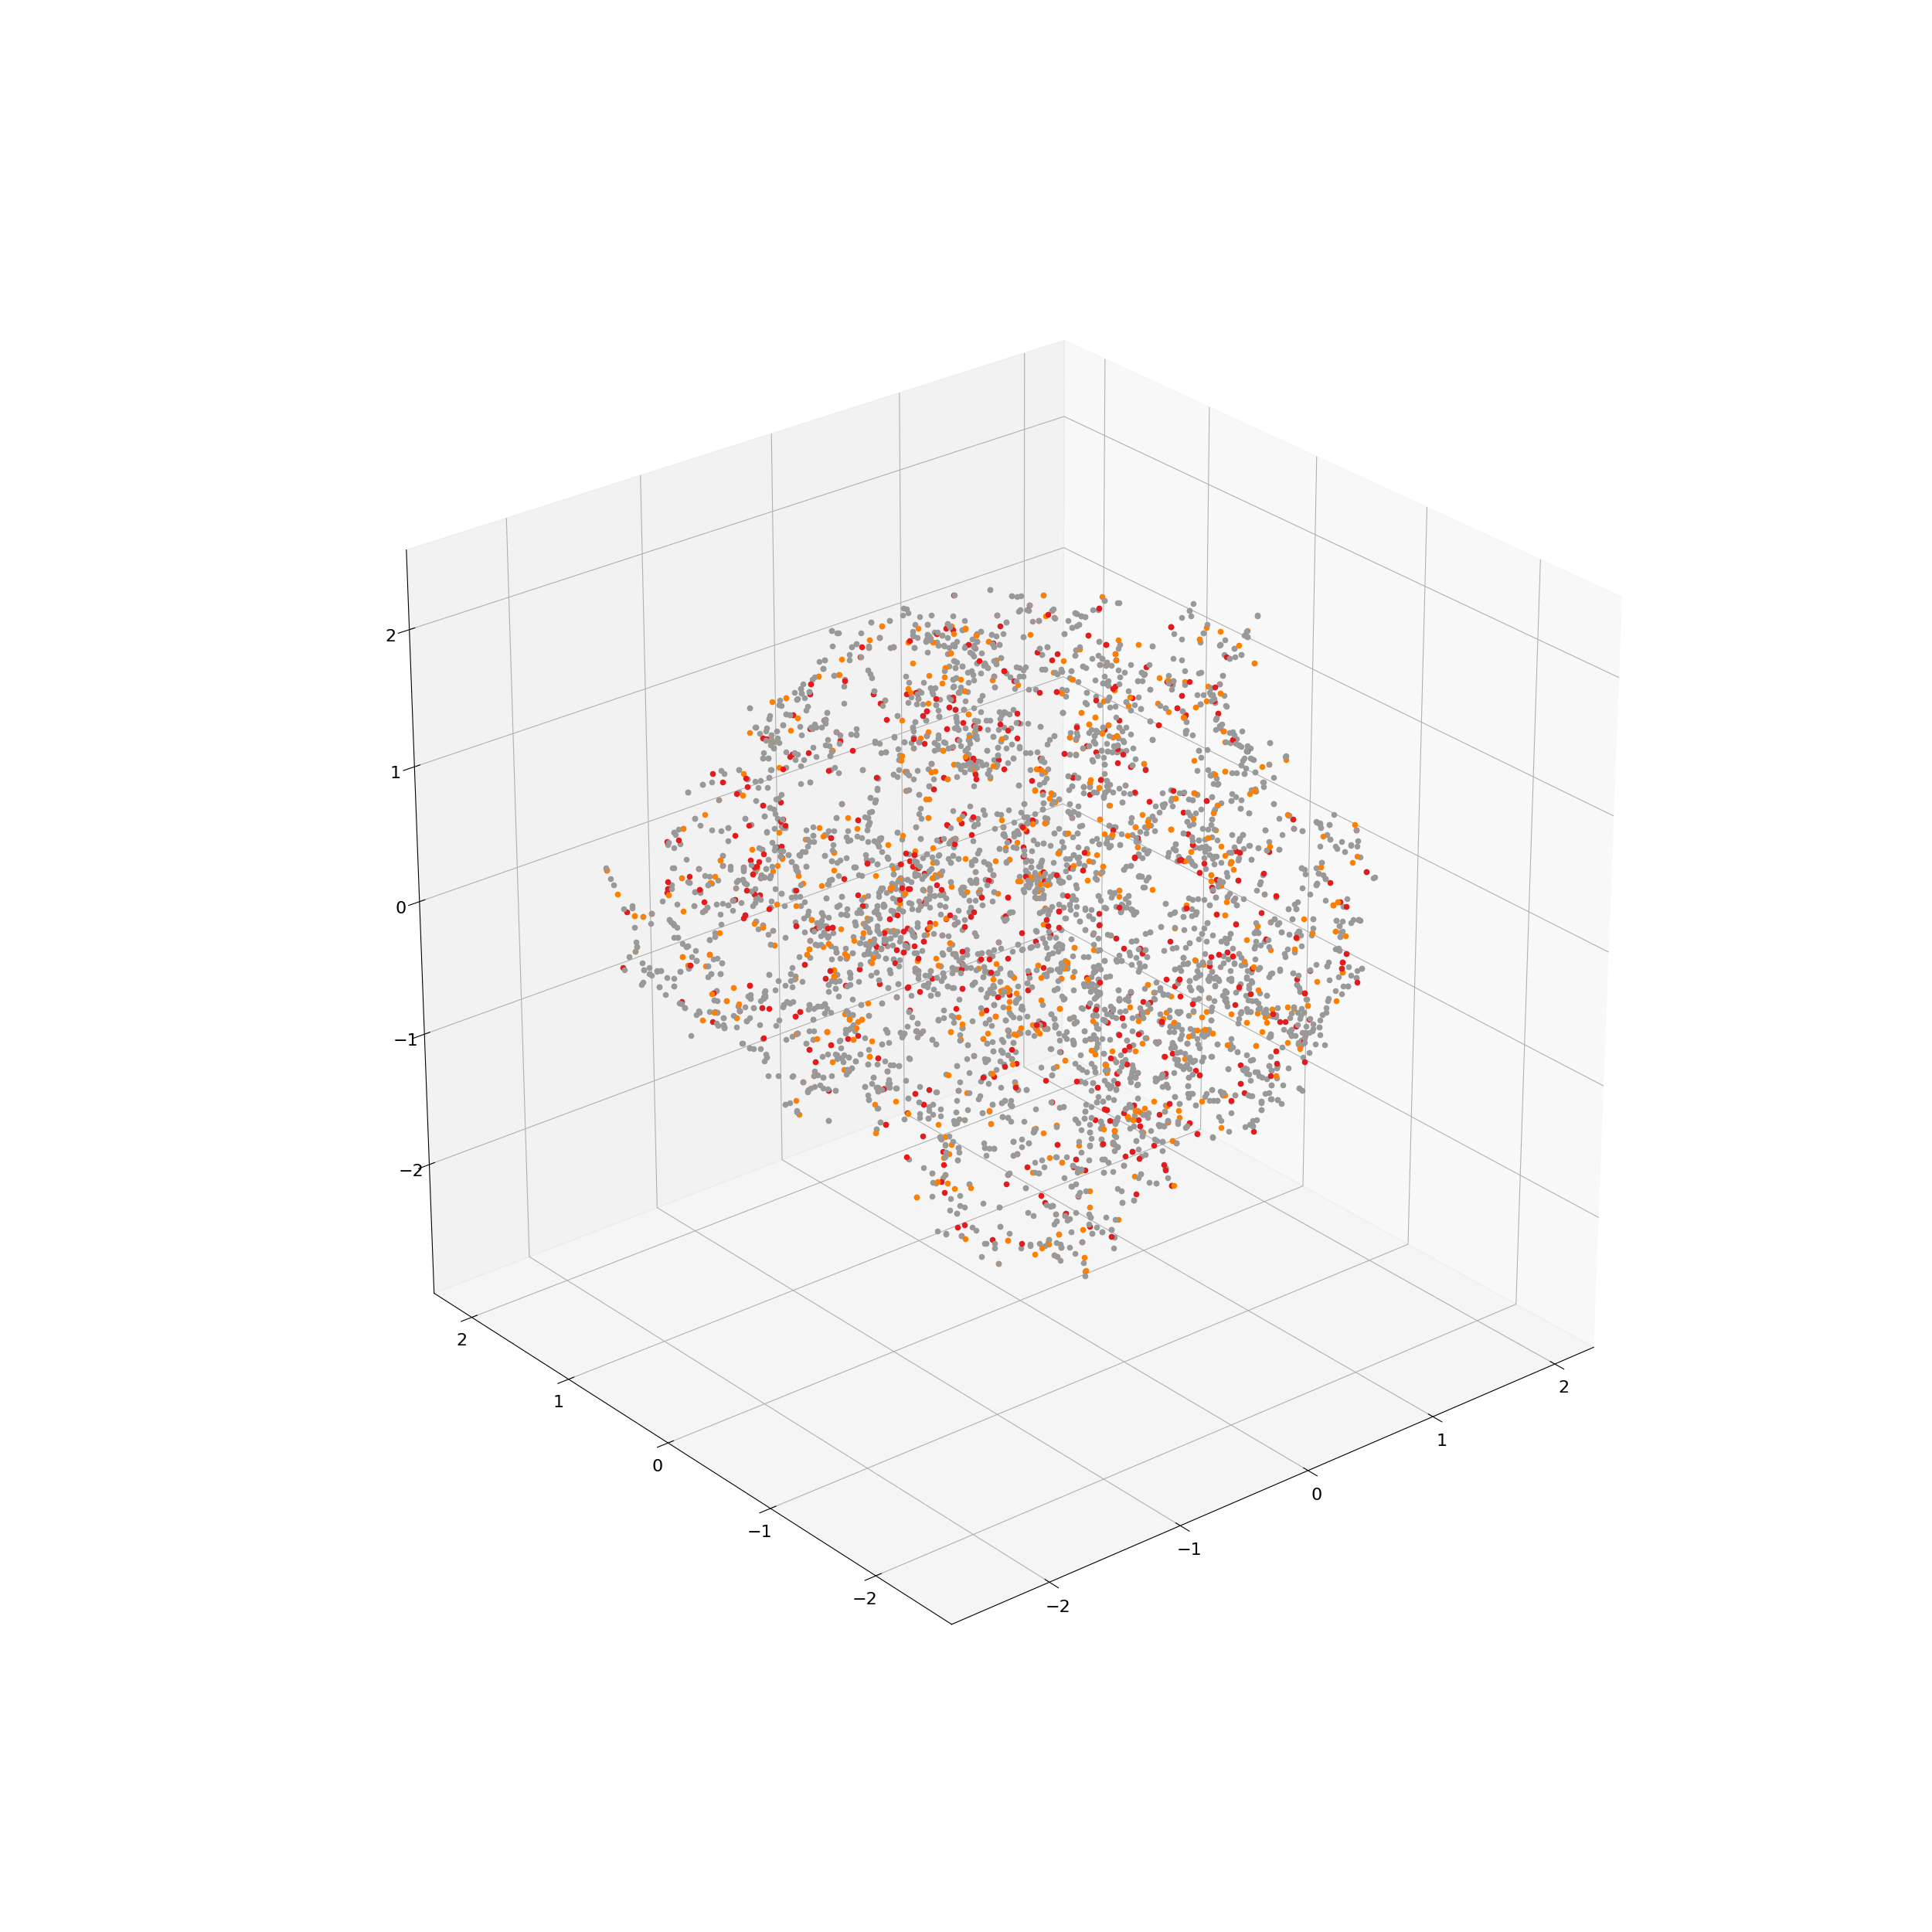

100%|██████████| 5000/5000 [00:20<00:00, 242.56it/s]


In [73]:
%matplotlib notebook
nb_classes = 2
fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111,projection='3d')

plt.grid()
for i in tqdm.tqdm(range(5000)):
    label_id = color_position[i] #argmax(g[i])
    ax.scatter(tsne_result_scaled[i,0], 
               tsne_result_scaled[i,1], 
               tsne_result_scaled[i,2], 
               color= plt.cm.Set1(label_id / float(nb_classes)))

## Yet another model

In [9]:

def build_conv2D_pointwise_encoder(custom_shape= INPUT_ENCODER_SHAPE):

    inputs = tf.keras.Input(shape=custom_shape, name='encoder_input')

    x = tf.keras.layers.Lambda(lambda x: x[:, :, :, 0])(inputs)
    x = tf.keras.layers.Reshape((IMG_SIZE, IMG_SIZE, 1))(x)

    y = tf.keras.layers.Lambda(lambda x: x[:, :, :, 1])(inputs)
    y = tf.keras.layers.Reshape((IMG_SIZE, IMG_SIZE, 1))(y)

    #fx = tf.keras.layers.Flatten()(x)
    fx = tf.keras.layers.Conv2D(filters=LATENT_DIM, kernel_size=3, strides=(
        2, 2), activation='relu', name='conv_x_1')(x)
    fx = tf.keras.layers.Conv2D(filters=LATENT_DIM * 2, kernel_size=3,
                                strides=(2, 2), activation='relu', name='conv_x_2')(fx)
    fx = tf.keras.layers.Flatten()(fx)
    #fx = tf.keras.layers.Dense(units=15*15*64, name = 'latent_fx1')(fx)
    fx = tf.keras.layers.Dense(LATENT_DIM, name='latent_fx2')(fx)
    fx = tf.keras.layers.Reshape((LATENT_DIM, 1,))(fx)

    #fy = tf.keras.layers.Flatten()(y)
    fy = tf.keras.layers.Conv2D(filters=LATENT_DIM, kernel_size=3, strides=(
        2, 2), activation='relu', name='conv_y_1')(y)
    fy = tf.keras.layers.Conv2D(filters=LATENT_DIM * 2, kernel_size=3,
                                strides=(2, 2), activation='relu', name='conv_y_2')(fy)
    fy = tf.keras.layers.Flatten()(fy)
    #fy = tf.keras.layers.Dense(units=15*15*64, name = 'latent_fy1')(fy)
    fy = tf.keras.layers.Dense(LATENT_DIM, name='latent_fy2')(fy)
    fy = tf.keras.layers.Reshape((LATENT_DIM,1,))(fy)

    matmul = tf.keras.layers.Multiply()([fx, fy])

    fh = tf.keras.layers.Flatten()(matmul)
    fh = tf.keras.layers.Dense(LATENT_DIM, name='latent_fh1')(fh)
    #fh = tf.keras.layers.Dense(LATENT_DIM, name = 'latent_fh2')(fh)
    #fh = tf.keras.layers.Dense(LATENT_DIM, name = 'latent_fh3')(fh)

    fx = tf.keras.layers.Reshape((1, LATENT_DIM,))(fx)
    fh = tf.keras.layers.Reshape((1, LATENT_DIM,))(fh)

    outputs = tf.keras.layers.Concatenate()([fx, fh])
    encoder = tf.keras.Model(
        inputs=inputs, outputs=outputs, name='encoder_model')

    return encoder

    

In [10]:
enc = build_conv2D_pointwise_encoder()

In [11]:
enc.summary()

Model: "encoder_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64, 64, 2)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 64, 64)       0           encoder_input[0][0]              
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 64, 64)       0           encoder_input[0][0]              
__________________________________________________________________________________________________
reshape (Reshape)               (None, 64, 64, 1)    0           lambda[0][0]                     
______________________________________________________________________________________

### On continue l'analyse